Tree analysis - Bone marrow fates
=================================

This notebook reproduces the figure 2 from the supplementary method of the package manuscript. It consists in preprocessing human bone marrow dataset from Palantir paper, tree learning, feature testing and fitting, branch DE and bifurcation analysis



## Setting up environment modules and basic settings

### Generating the environment

The following needs to be run in the command-line

```bash
conda create -n scFates -c conda-forge -c r python=3.8 r-mgcv rpy2=3.4.2 -y
conda activate scFates

# Install new jupyter server
conda install -c conda-forge jupyter

# Or add to an existing jupyter server
conda install -c conda-forge ipykernel
python -m ipykernel install --user --name scFates --display-name "scFates"

# Install scFates
pip install scFates
```

### Required additional packages

In [1]:
import sys
!{sys.executable} -m pip -q install palantir fa2

### Loading modules and settings

In [2]:
import warnings
warnings.filterwarnings("ignore")
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import palantir
import matplotlib.pyplot as plt
sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout
## fix palantir breaking down some plots
import seaborn 
seaborn.reset_orig()
%matplotlib inline

sc.set_figure_params()
scf.set_figure_pubready()

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


## Preprocessing pipeline from Palantir

This cell follows the [palantir tutorial notebook](https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb) with some slight changes. Doing palantir diffusion maps is usually a good pre-preprocessing step before using elpigraph or ppt.

### Load, normalize and log-transform count data

In [3]:
counts = palantir.io.from_csv('https://github.com/dpeerlab/Palantir/raw/master/data/marrow_sample_scseq_counts.csv.gz')
norm_df = sc.pp.normalize_per_cell(counts,copy=True)
norm_df = palantir.preprocess.log_transform(norm_df)

### Perform PCA on highly variable genes

In [4]:
adata=sc.AnnData(norm_df)
sc.pp.highly_variable_genes(adata, n_top_genes=1500, flavor='cell_ranger')
sc.pp.pca(adata)
pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


### Run Palantir to obtain multiscale diffusion space

In [5]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


### Generate embedding from the multiscale diffusion space

In [6]:
# generate neighbor draph in multiscale diffusion space
adata.obsm["X_palantir"]=ms_data.values
sc.pp.neighbors(adata,n_neighbors=30,use_rep="X_palantir")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [7]:
# draw ForceAtlas2 embedding using 2 first PCs as initial positions
adata.obsm["X_pca2d"]=adata.obsm["X_pca"][:,:2]
sc.tl.draw_graph(adata,init_pos='X_pca2d')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:24)


### Plotting results

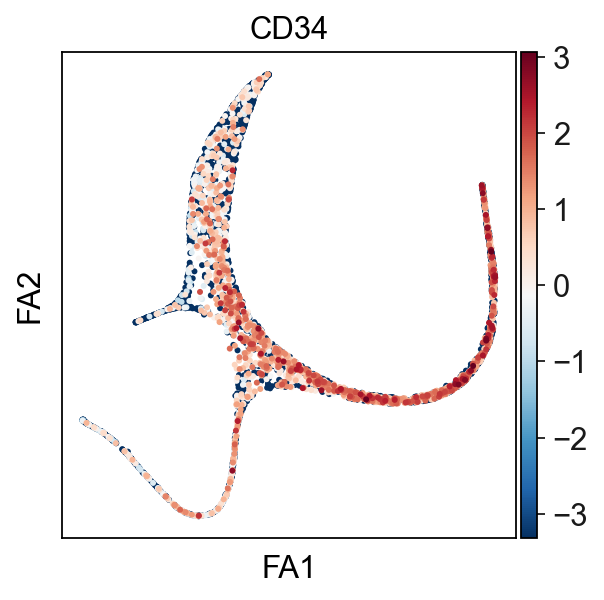

In [8]:
sc.set_figure_params()
sc.pl.draw_graph(adata,color="CD34",color_map="RdBu_r")

## Tree learning with SimplePPT

In [9]:
scf.tl.tree(adata,method="ppt",Nodes=200,use_rep="palantir",
            device="cpu",seed=1,ppt_lambda=100,ppt_sigma=0.025,ppt_nsteps=200)

inferring a principal tree inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.025, lambda = 100, metric = euclidean
    fitting:  71%|███████   | 142/200 [00:09<00:03, 15.61it/s]
    converged
    finished (0:00:09) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


### projecting results onto ForceAtlas2 embedding

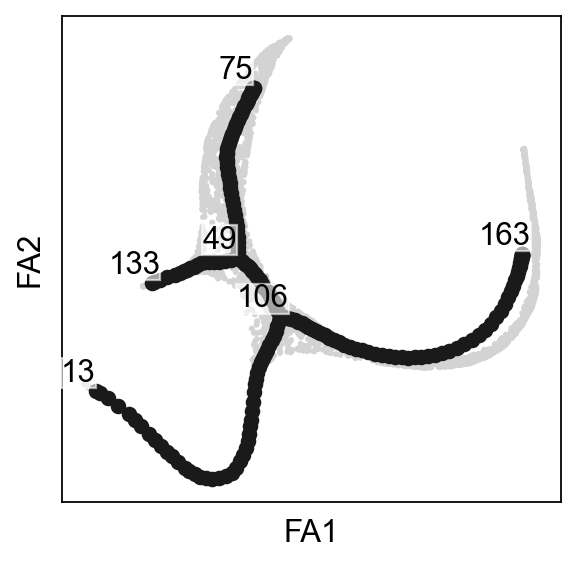

In [10]:
scf.pl.graph(adata)

### Selecting a root and computing pseudotime
Using CD34 marker, we can confidently tell that the tip 163 is the root.

In [11]:
scf.tl.root(adata,163)

node 163 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


Here we are going to generate 100 mappings of pseudotime, to account for cell asssignment uncertainty. to **.obs** will be saved the mean of all calculated pseudotimes.

In [12]:
scf.tl.pseudotime(adata,n_jobs=20,n_map=100,seed=42)

projecting cells onto the principal graph
    mappings: 100%|██████████| 100/100 [00:42<00:00,  2.36it/s]
    finished (0:00:45) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


## Representing the trajectory and tree

### on top of existing embedding

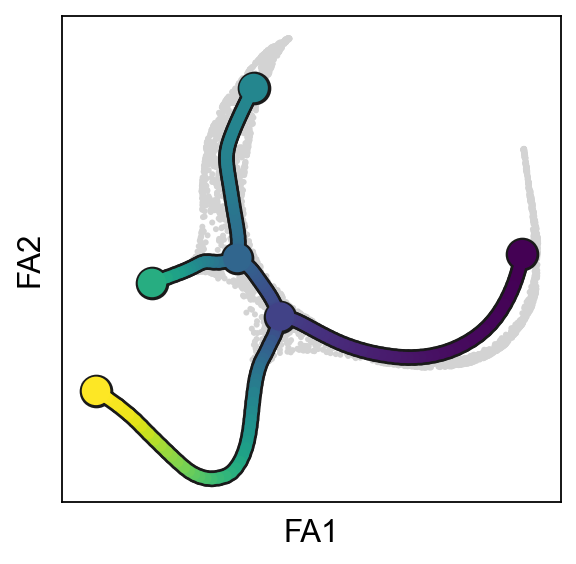

In [13]:
scf.pl.trajectory(adata)

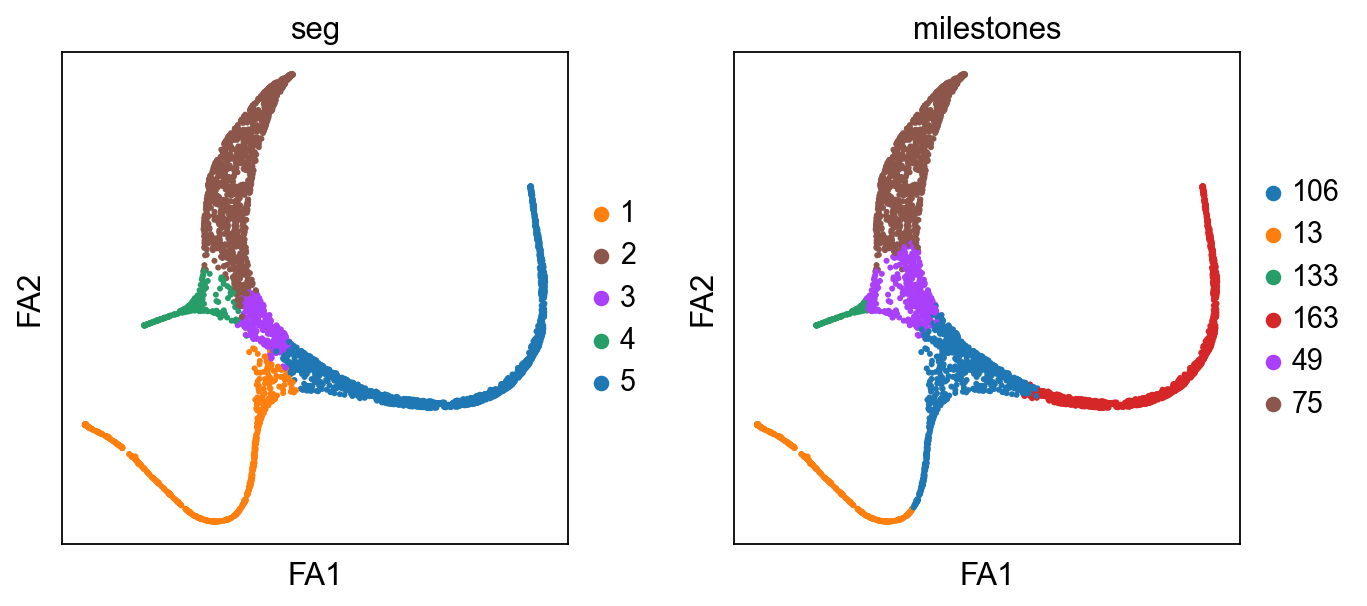

In [14]:
sc.pl.draw_graph(adata,color=["seg","milestones"])
scf.tl.rename_milestones(adata,["bifA","Ery","DC","Root","BifB","Mono"])
# we change the color of the root milestone for better visualisations
adata.uns["milestones_colors"][3]="#17bece" 

In [15]:
from pathlib import Path
Path("figures/").mkdir(parents=True, exist_ok=True)

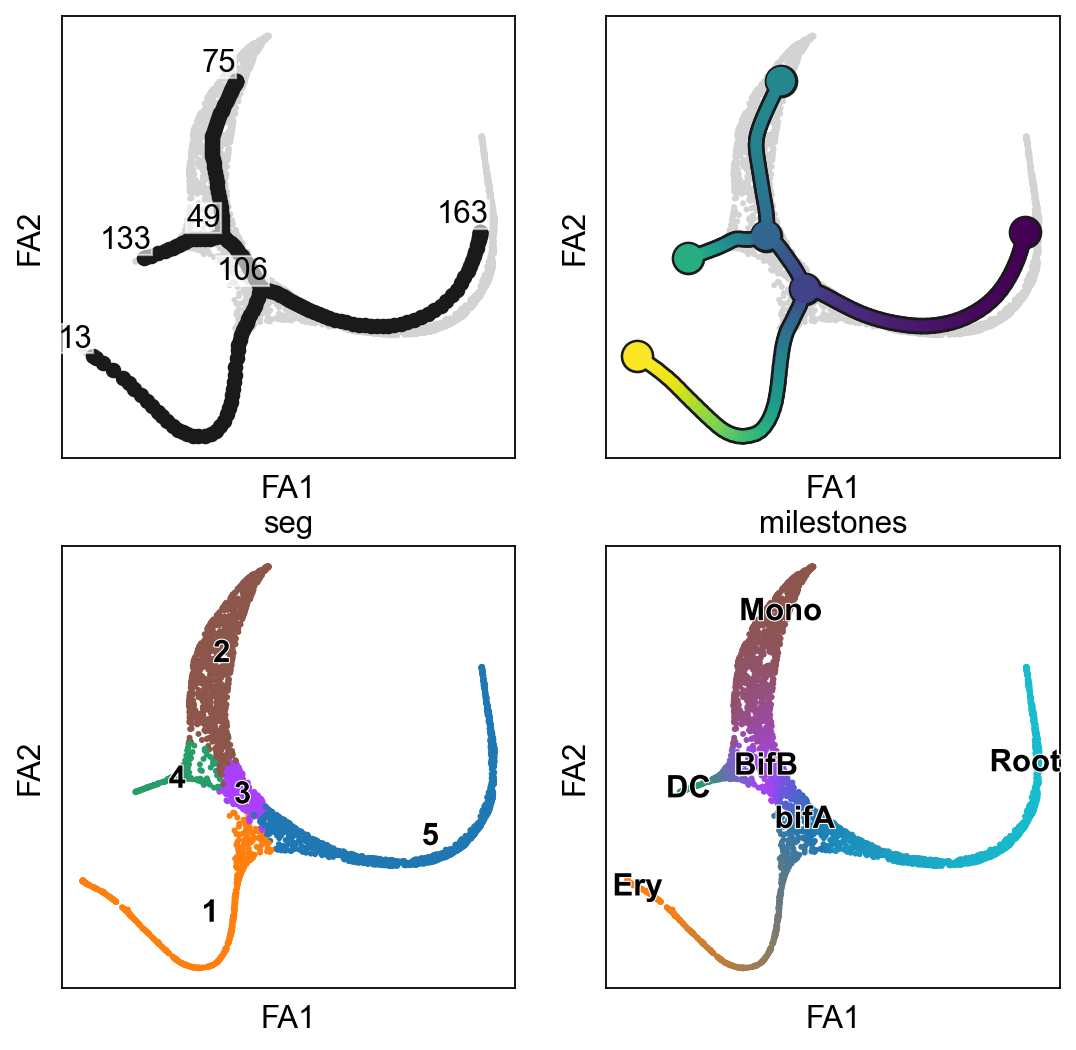

In [16]:
sc.set_figure_params()
fig, axs=plt.subplots(2,2,figsize=(8,8))
axs=axs.ravel()
scf.pl.graph(adata,basis="draw_graph_fa",show=False,ax=axs[0])
scf.pl.trajectory(adata,basis="draw_graph_fa",show=False,ax=axs[1])
sc.pl.draw_graph(adata,color=["seg"],legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True)
scf.pl.milestones(adata,ax=axs[3],show=False,annotate=True)
plt.savefig("figures/A.pdf",dpi=300)

### as a dendrogram representation

In [17]:
scf.tl.dendrogram(adata)

Generating dendrogram of tree
    segment : 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]
    finished (0:00:15) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


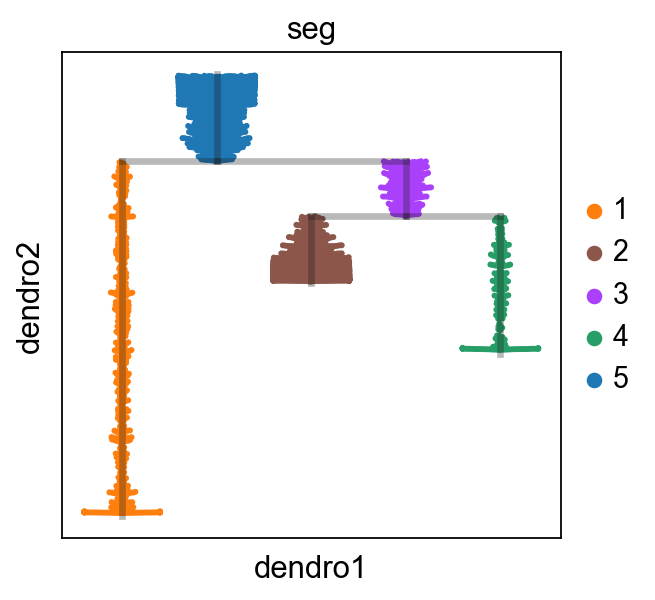

In [18]:
scf.pl.dendrogram(adata,color="seg")

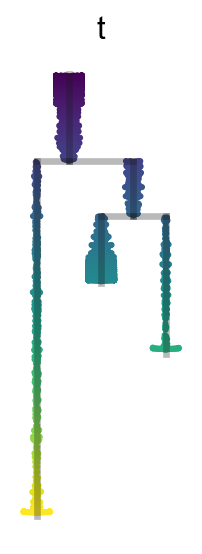

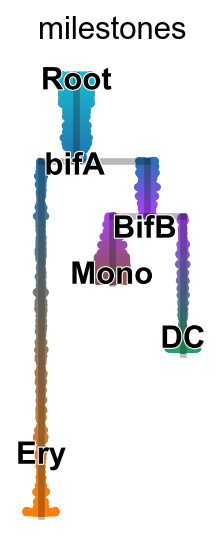

In [19]:
sc.set_figure_params(figsize=(1.5,4),frameon=False,dpi_save=300)
scf.pl.dendrogram(adata,color="t",show_info=False,save="B1.pdf",cmap="viridis")
scf.pl.dendrogram(adata,color="milestones",legend_loc="on data",color_milestones=True,legend_fontoutline=True,save="B2.pdf")

## Test and fit features associated with the tree

Let's find out which genes are significantly changing along the tree.

In [20]:
scf.tl.test_association(adata,n_jobs=20)

test features for association with the trajectory
    single mapping : 100%|██████████| 16106/16106 [04:43<00:00, 56.81it/s]
    found 3387 significant features (0:04:43) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


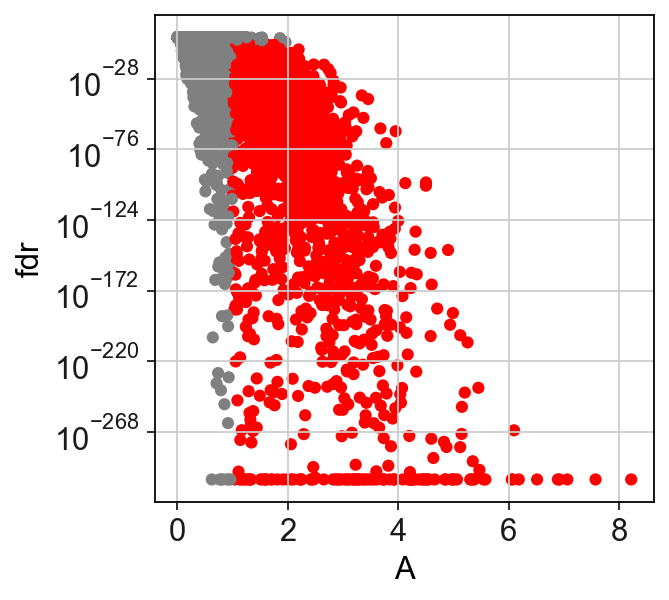

In [21]:
sc.set_figure_params()
scf.pl.test_association(adata)
plt.savefig("figures/C.pdf",dpi=300)

We can now fit the significant genes.

<div class="alert alert-warning">
    
**Warning**

anndata format can currently only keep the same dimensions for each of its layers. This means that adding the layer for fitted features will lead to dataset subsetted to only those! 

By default the function fit will keep the whole dataset under **adata.raw** (parameter save_raw set to True by default)

</div>

In [22]:
scf.tl.fit(adata,n_jobs=20)

fit features associated with the trajectory
    single mapping : 100%|██████████| 3387/3387 [03:13<00:00, 17.51it/s]
    finished (adata subsetted to keep only fitted features!) (0:03:18) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


## Plotting single features

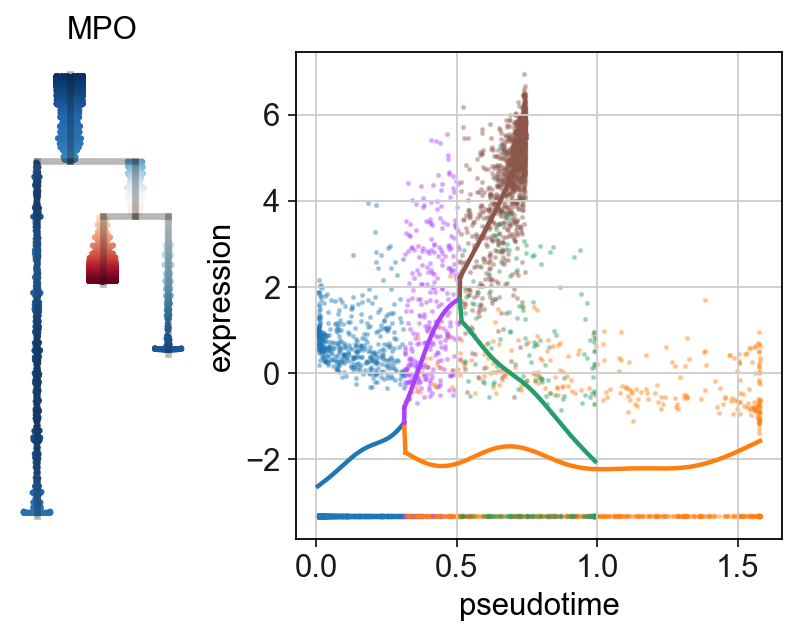

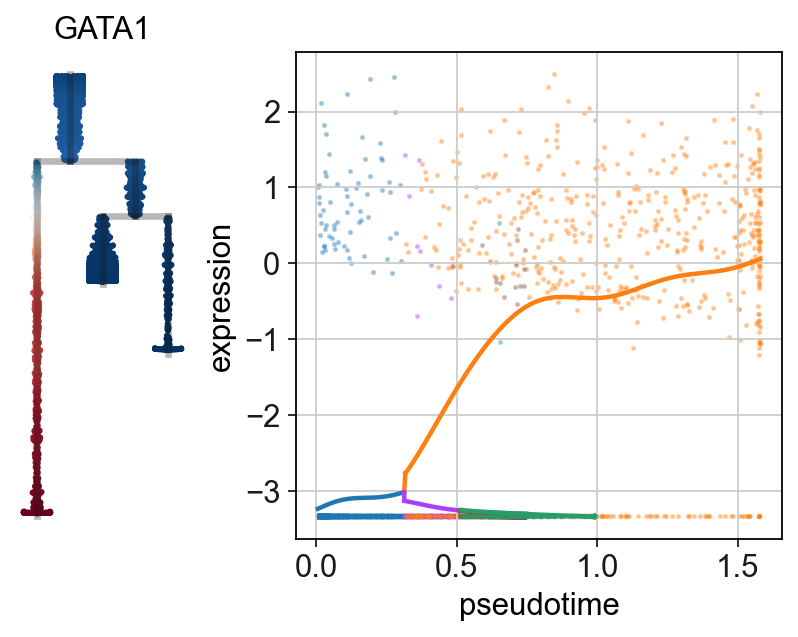

In [23]:
sc.set_figure_params(figsize=(.8,4),frameon=False)
scf.set_figure_pubready()
scf.pl.single_trend(adata,"MPO",basis="dendro",wspace=-.25,save="_E1.pdf")
scf.pl.single_trend(adata,"GATA1",basis="dendro",wspace=-.25,save="_E2.pdf")

## All branches DE analysis

We are here testing for differential expression between all branches, the `rescale` parameter is used to considered all cells in each branch, regardless of their pseudotime:

In [24]:
scf.tl.test_fork(adata,root_milestone="Root",milestones=["DC","Mono","Ery"],n_jobs=20,rescale=True)

testing fork
    single mapping
    Differential expression: 100%|██████████| 3387/3387 [01:29<00:00, 38.02it/s]
    test for upregulation for each leave vs root
    upreg Ery: 100%|██████████| 1558/1558 [00:01<00:00, 932.98it/s] 
    finished (0:01:34) --> added 
    .uns['Root->DC<>Mono<>Ery']['fork'], DataFrame with fork test results.


We can keep the features which display the strongest amplitude difference:

In [25]:
scf.tl.branch_specific(adata,root_milestone="Root",milestones=["DC","Mono","Ery"],effect=2)

    branch specific features: Ery: 30, DC: 15, Mono: 11
    finished --> updated 
    .uns['Root->DC<>Mono<>Ery']['fork'], DataFrame updated with additionnal 'branch' column.


### Displaying results using heatmap plots

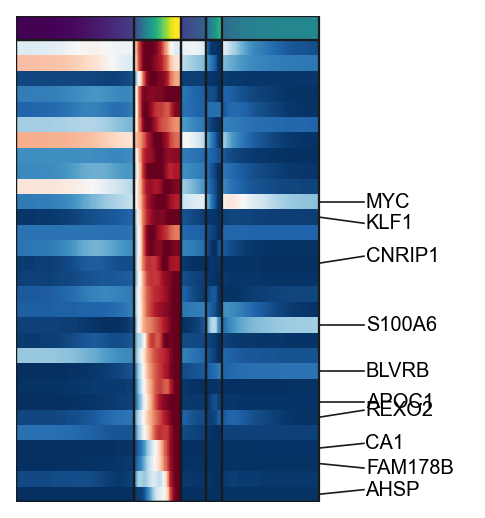

In [26]:
g1=scf.pl.trends(adata, 
                 root_milestone="Root", 
                 milestones=["DC","Mono","Ery"],
                 branch="Ery",
                 plot_emb=False,ordering="max",return_genes=True)


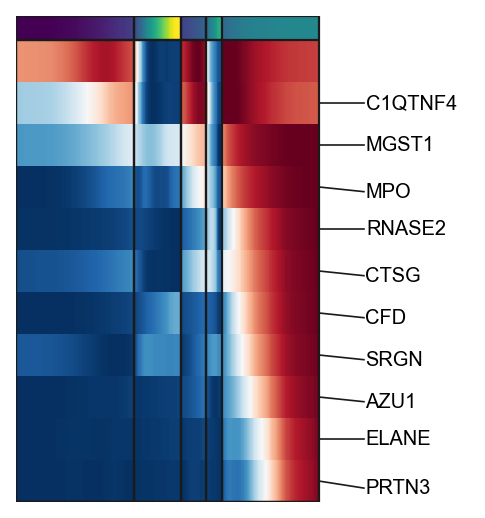

In [27]:
g2=scf.pl.trends(adata, 
                 root_milestone="Root", 
                 milestones=["DC","Mono","Ery"],
                 branch="Mono",
                 plot_emb=False,ordering="max",return_genes=True)


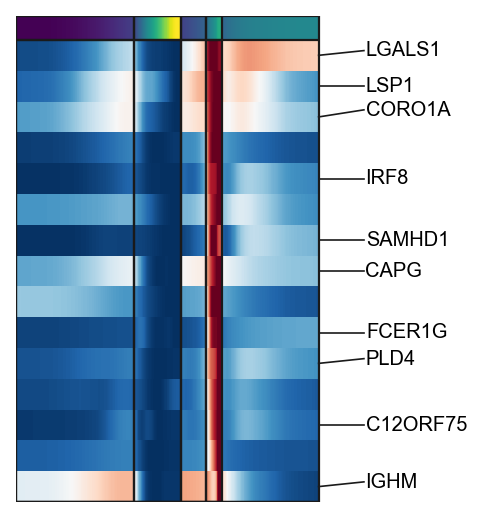

In [28]:
g3=scf.pl.trends(adata, 
                 root_milestone="Root", 
                 milestones=["DC","Mono","Ery"],
                 branch="DC",
                 plot_emb=False,ordering="max",return_genes=True)


In [29]:
gg=g1.tolist()+g3.tolist()+g2.tolist()

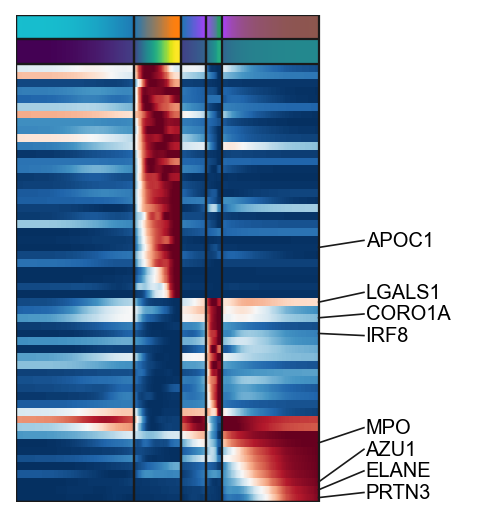

In [30]:
import matplotlib.pyplot as plt
g=scf.pl.trends(adata,gg,figsize=(4,4),annot="milestones",n_features=8,
        plot_emb=False,ordering=None,return_genes=True)
plt.savefig("figures/D.pdf",dpi=300)

### Displaying results using matrix plot

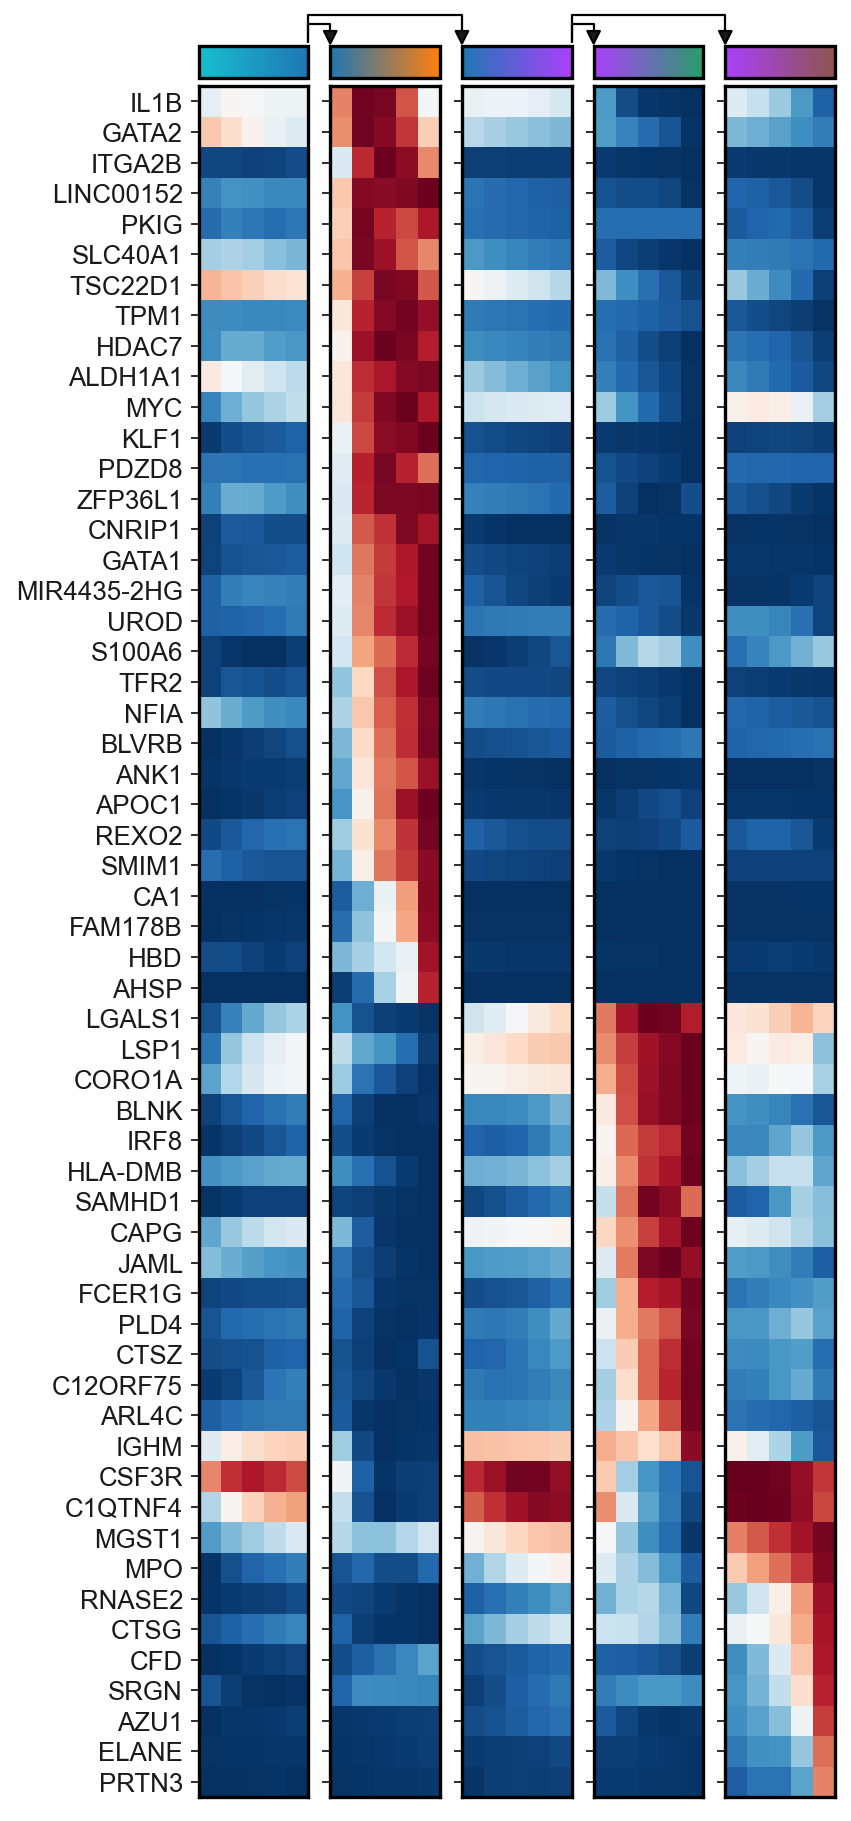

In [31]:
sc.set_figure_params()
scf.pl.matrix(adata,gg,norm="minmax",cmap="RdBu_r",colorbar=False,save="_F.pdf")

## Bifurcation analysis

Let's now focus on a specific bifurcation, where we can apply more advanced functions to detect early biasing

In [32]:
scf.tl.test_fork(adata,root_milestone="Root",milestones=["DC","Mono"],n_jobs=20,rescale=True)

testing fork
    single mapping
    Differential expression: 100%|██████████| 3387/3387 [00:43<00:00, 78.32it/s]
    test for upregulation for each leave vs root
    upreg Mono: 100%|██████████| 781/781 [00:01<00:00, 695.72it/s]
    finished (0:00:48) --> added 
    .uns['Root->DC<>Mono']['fork'], DataFrame with fork test results.


In [33]:
scf.tl.branch_specific(adata,root_milestone="Root",milestones=["DC","Mono"],effect=1.7)

    branch specific features: DC: 64, Mono: 23
    finished --> updated 
    .uns['Root->DC<>Mono']['fork'], DataFrame updated with additionnal 'branch' column.


### Early gene detection

Here we use the linear model approach to detect early genes. We test $g_i \sim pseudotime$ in the progenitor branch only to estimate if the feature displays an upward trend before the fork

In [34]:
scf.tl.activation_lm(adata,root_milestone="Root",milestones=["DC","Mono"],n_jobs=20)

    single mapping
    prefork activation: 100%|██████████| 87/87 [00:00<00:00, 476.54it/s]
    41 early and 23 late features specific to leave DC
    15 early and 8 late features specific to leave Mono
    finished (0:00:00) --> updated 
    .uns['Root->DC<>Mono']['fork'], DataFrame updated with additionnal 'slope','pval','fdr','prefork_signi' and 'module' columns.


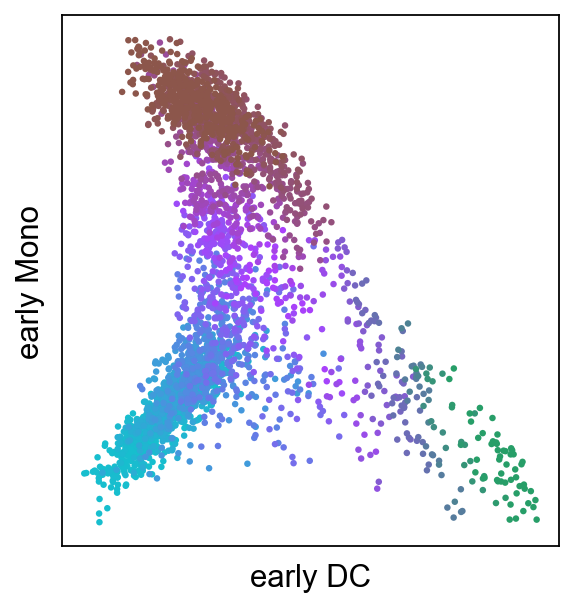

In [35]:
scf.pl.modules(adata,root_milestone="Root",milestones=["DC","Mono"],
               smooth=True,module="early",save="_G.pdf")

### Repulsion of early gene modules

For that we need to create non-interesecting windows of cells along the tree:

In [36]:
scf.tl.slide_cells(adata,root_milestone="Root",milestones=["DC","Mono"],win=400)

--> added 
    .uns['Root->DC<>Mono']['cell_freq'], probability assignment of cells on 9 non intersecting windows.


In each of the windows we obtain gene-gene correlation of both branch specific ealry modules.

In [37]:
scf.tl.slide_cors(adata,root_milestone="Root",milestones=["DC","Mono"])

--> added 
    .uns['Root->DC<>Mono']['corAB'], gene-gene correlation modules.


Let’s plot the results:

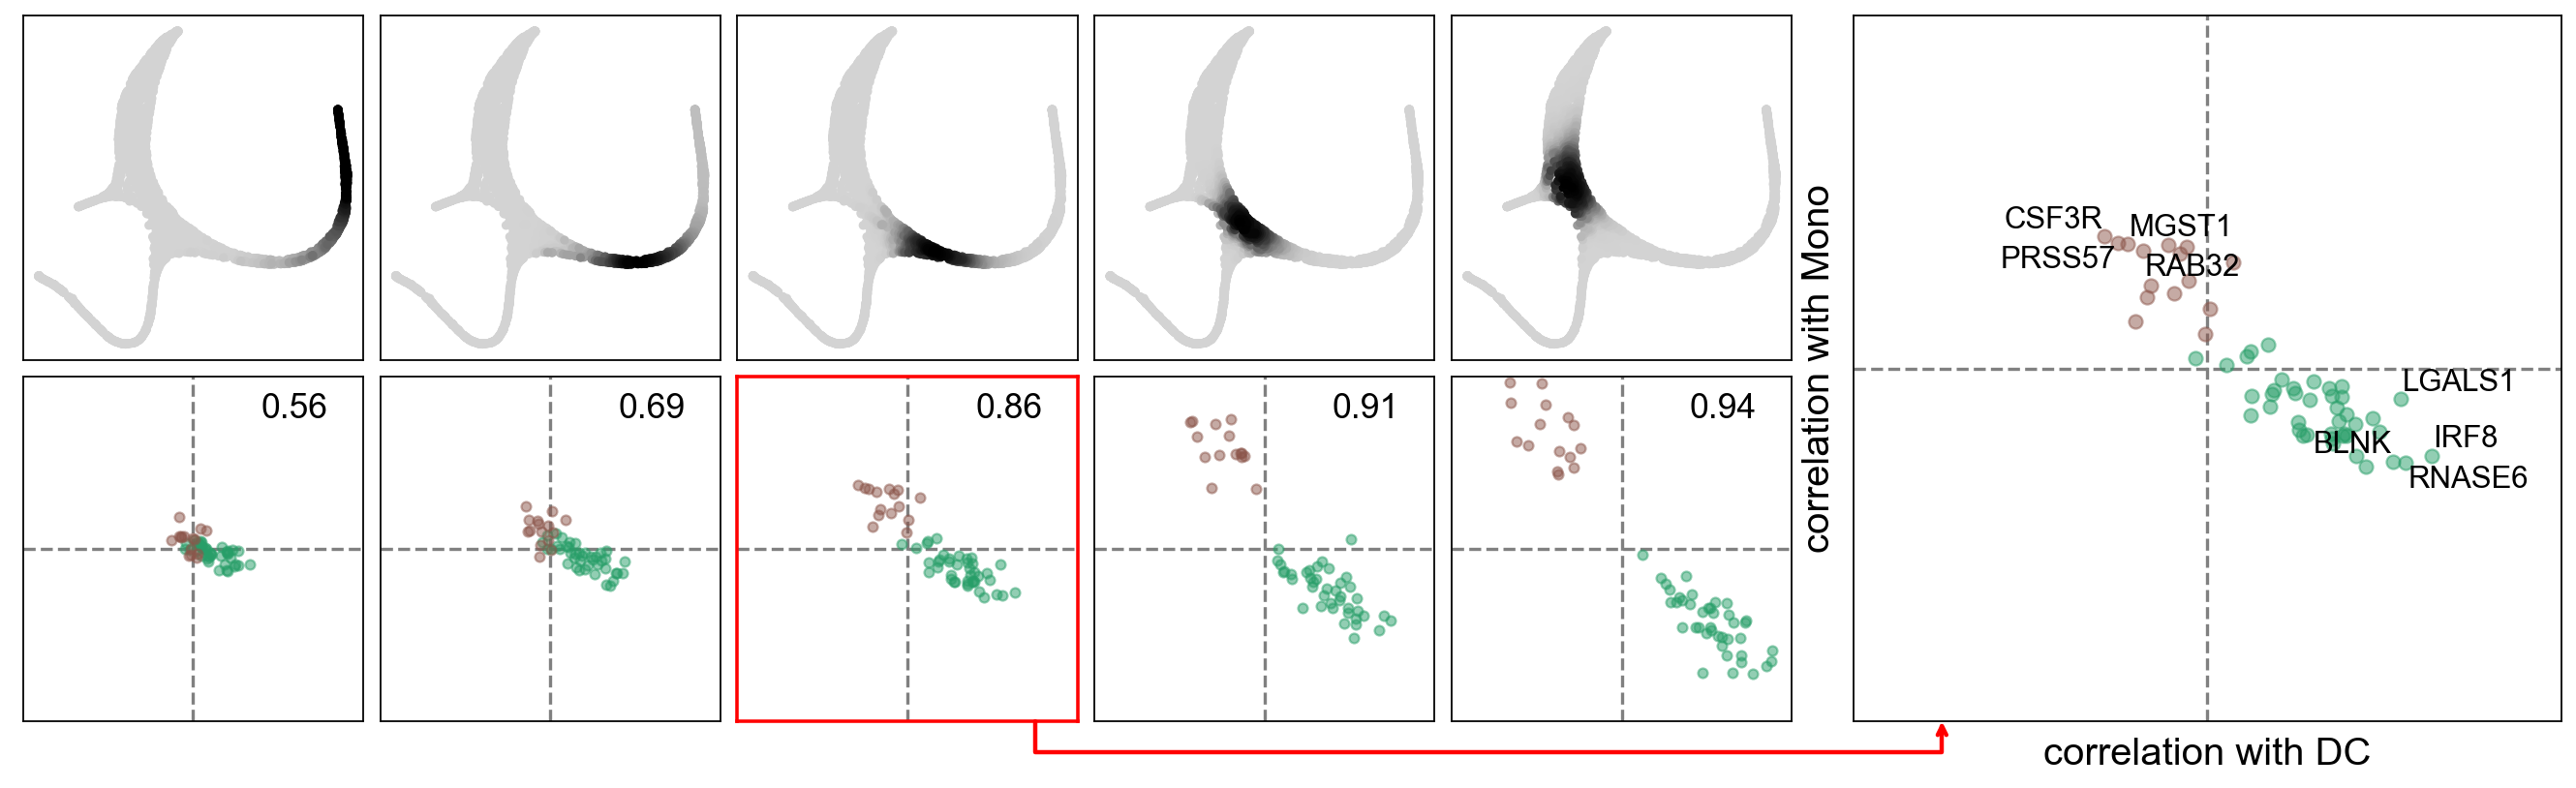

In [38]:
sc.set_figure_params()
scf.pl.slide_cors(adata,root_milestone="Root",milestones=["DC","Mono"],basis="draw_graph_fa",win_keep=[0,2,3,4,5],
                 focus=2,save="_H.pdf")

We can see a repulsion and mutual negative correlation prior to the bifurcation, indicating a possible competition of gene programs prior to the bifurcation.

### Local trend of module correlations

In order to investigate more precisely the competition of programs prior to bifurcation, we can compute local correlation on a sliding intersecting windows of cells:

In [39]:
scf.tl.synchro_path(adata,root_milestone="Root",milestones=["DC","Mono"],w=100,n_map=50,n_jobs=20)

computing local correlations
    multi mapping permutations: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]
    finished (0:00:37) --> added 
    .uns['Root->DC<>Mono']['synchro'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor Root->DC<>Mono'], GAM fit of inter-module mean local gene-gene correlations prior to bifurcation.


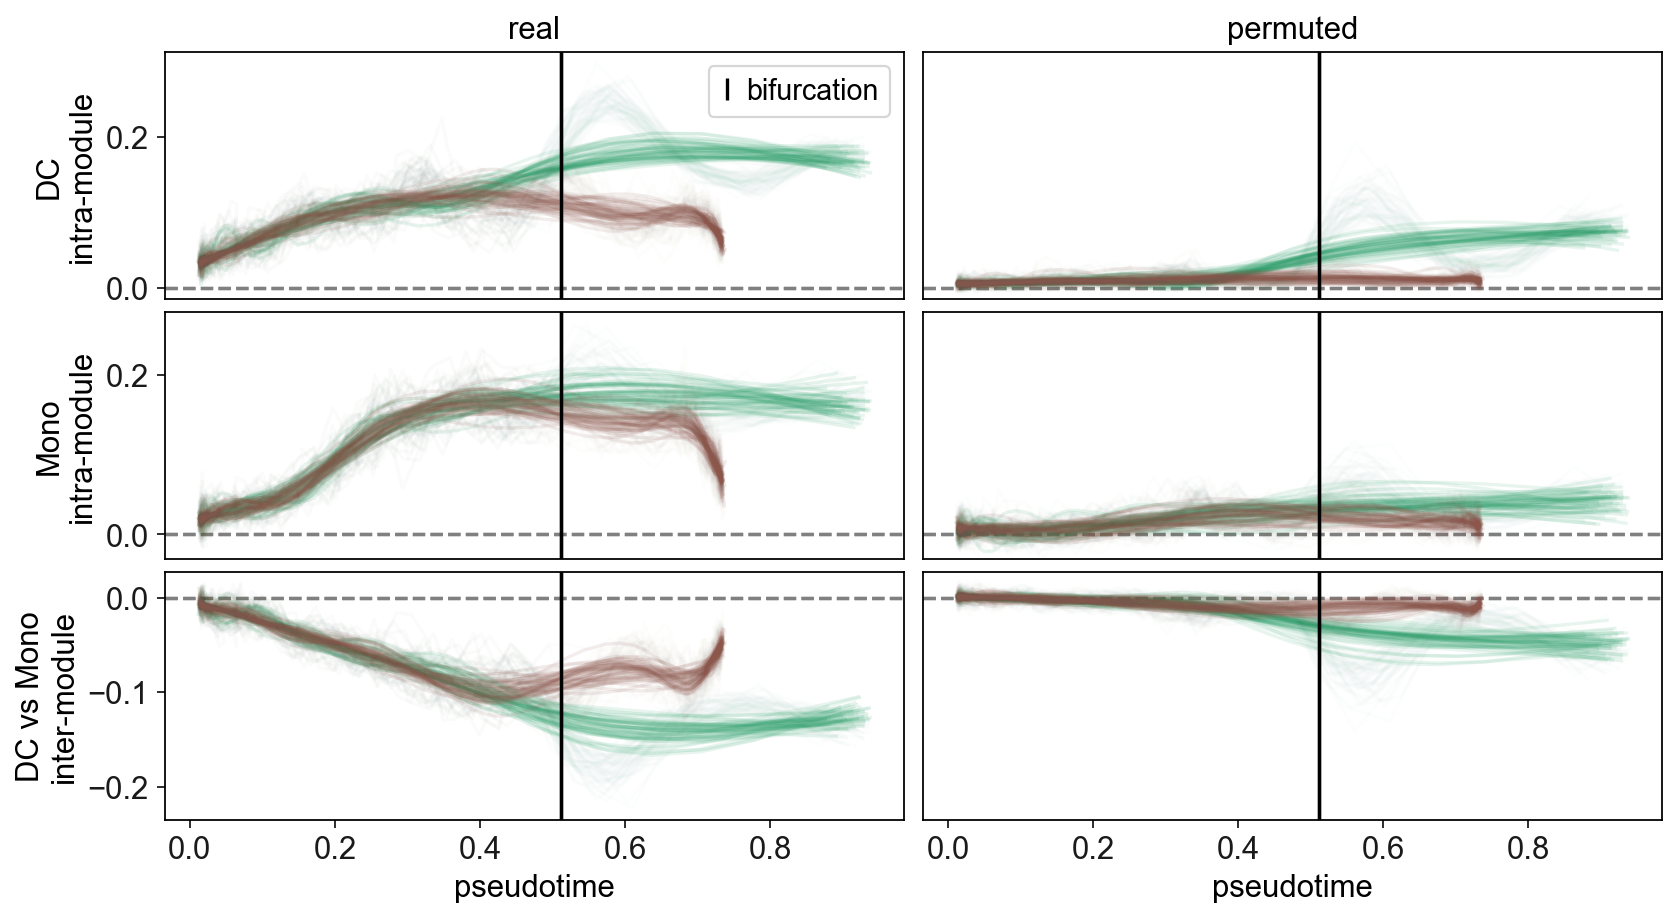

In [40]:
scf.pl.synchro_path(adata,root_milestone="Root",milestones=["DC","Mono"],save="_I.pdf")

Here we see that negative local correlation between the two modules is present at very early pseudotime, even from the start of the trajectory! This indicates that cells are already undergoing biasing before reaching the fork.

### Formation of fate-specific modules

In order to study decision-making process prior to the tree-reconstructed bifurcation point, a framework is provided to identify the timing of gene inclusion into its module

In [41]:
scf.tl.module_inclusion(adata,root_milestone="Root",milestones=["DC","Mono"],n_jobs=20,n_map=50,parallel_mode="mappings")

Calculating onset of features within their own module
    multi mapping: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]
    finished (0:01:11) --> added 
    .uns['Root->DC<>Mono']['module_inclusion'], milestone specific dataframes containing inclusion timing for each gene in each probabilistic cells projection.
    .uns['Root->DC<>Mono']['fork'] has been updated with the column 'inclusion'.


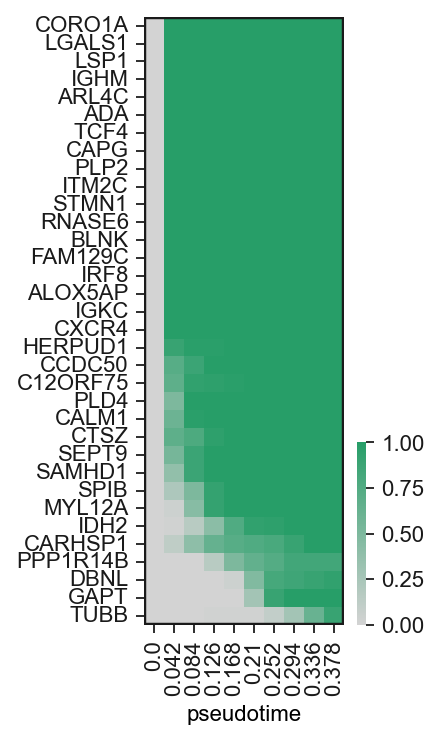

In [42]:
sc.set_figure_params(fontsize=10)
scf.pl.module_inclusion(adata,root_milestone="Root",milestones=["DC","Mono"],
                        bins=10,branch="DC",save="_J1.pdf",figsize=(2,5))

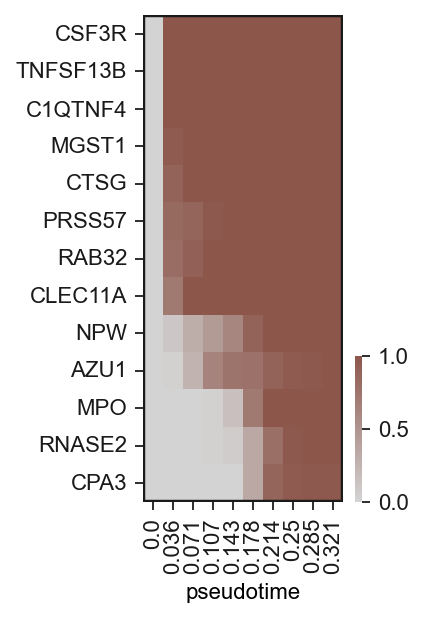

In [43]:
scf.pl.module_inclusion(adata,root_milestone="Root",milestones=["DC","Mono"],bins=10,branch="Mono",
                       save="_J2.pdf",figsize=(2,4))

## Generating the figure

In order to generate the figure, we need to install latex compiler tectonic with Arial fonts (additionally, ImageMagick to convert PDF into image):

```bash
conda install -c conda-forge mscorefonts imagemagick tectonic
```

In [44]:
fname="fig2_supplementary"
path="/".join(np.array(sys.executable.split("/"))[:-1])

In [45]:
%%bash -s $fname $path
cat<<EOF >$1.tex
\documentclass{article}
\usepackage[paperheight=270mm,paperwidth=210mm]{geometry}
\geometry{left=5mm,right=5mm,top=5mm,bottom=5mm,}

\usepackage{silence}
\WarningsOff*

\usepackage[labelfont=bf]{caption}

\usepackage[rgb]{xcolor}
\usepackage{fontspec}
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage{graphicx} 
\usepackage[export]{adjustbox}

\begin{document}
\setmainfont{Arial}

\noindent
\large 

\fontsize{11pt}{11pt}\selectfont

\raggedright \begin{minipage}[!ht]{0.67\textwidth}
\raggedright \begin{minipage}[t]{0.6\textwidth}
\vspace{0cm}
\textbf{A}\\

\includegraphics[width=\textwidth]{figures/A.pdf}
\end{minipage}\hfill
\raggedright \begin{minipage}[t]{0.11\textwidth}
\vspace{0cm}
\textbf{B}\\
\includegraphics[width=\textwidth]{figures/dendrogramB1.pdf}
\includegraphics[width=\textwidth]{figures/dendrogramB2.pdf}
\end{minipage}
\raggedright \begin{minipage}[t]{0.27\textwidth}
\vspace{0cm}
\textbf{C}\\
\includegraphics[width=\textwidth]{figures/C.pdf}

\textbf{D}\\
\includegraphics[width=\textwidth]{figures/D.pdf}
\end{minipage}

\textbf{E}\\

\raggedright \begin{minipage}[!ht]{0.5\textwidth}
\includegraphics[width=\textwidth]{figures/single_trend_E1.pdf}
\end{minipage}\hfill
\raggedright \begin{minipage}[!ht]{0.5\textwidth}
\includegraphics[width=\textwidth]{figures/single_trend_E2.pdf}
\end{minipage}\hfill
\end{minipage}\hfill
\raggedright \begin{minipage}[!ht]{0.315\textwidth}
\vspace{0cm}
\begin{minipage}[t]{\textwidth}
\vspace{0cm}
\textbf{F}\\

\includegraphics[width=\textwidth]{figures/matrix_F.pdf}
\end{minipage}\hfill
\end{minipage}
\hfill


\raggedright \begin{minipage}[t]{0.22\textwidth}
\raggedright \textbf{G}\\
\includegraphics[width=\textwidth]{figures/modules_G.pdf}
\end{minipage}\hfill
\raggedright \begin{minipage}[t]{0.78\textwidth}
\raggedright \textbf{H}\\
\includegraphics[width=\textwidth]{figures/slide_cors_H.pdf}
\end{minipage}\hfill

\raggedright \begin{minipage}[t]{0.59\textwidth}
\vspace{0cm}
\textbf{I}\\

\includegraphics[width=\textwidth]{figures/synchro_path_I.pdf}
\end{minipage}\hfill
\begin{minipage}[t]{0.41\textwidth}
\vspace{0cm}
\textbf{J}\\

\raggedright \begin{minipage}[!ht]{0.47\textwidth}
\includegraphics[width=\textwidth]{figures/module_inclusion_J1.pdf}
\end{minipage}\hfill
\raggedright \begin{minipage}[!ht]{0.5\textwidth}
\includegraphics[width=\textwidth]{figures/module_inclusion_J2.pdf}
\end{minipage}\hfill
\end{minipage}
\hfill

\clearpage
EOF
echo "\end{document}" >> $1.tex

$2/tectonic -c minimal $1.tex

$2/identify $1.pdf

$2/convert -flatten -density 300 $1.pdf $1.jpg

fig2_supplementary.pdf PDF 612x792 612x792+0+0 16-bit sRGB 3709B 0.000u 0:00.000


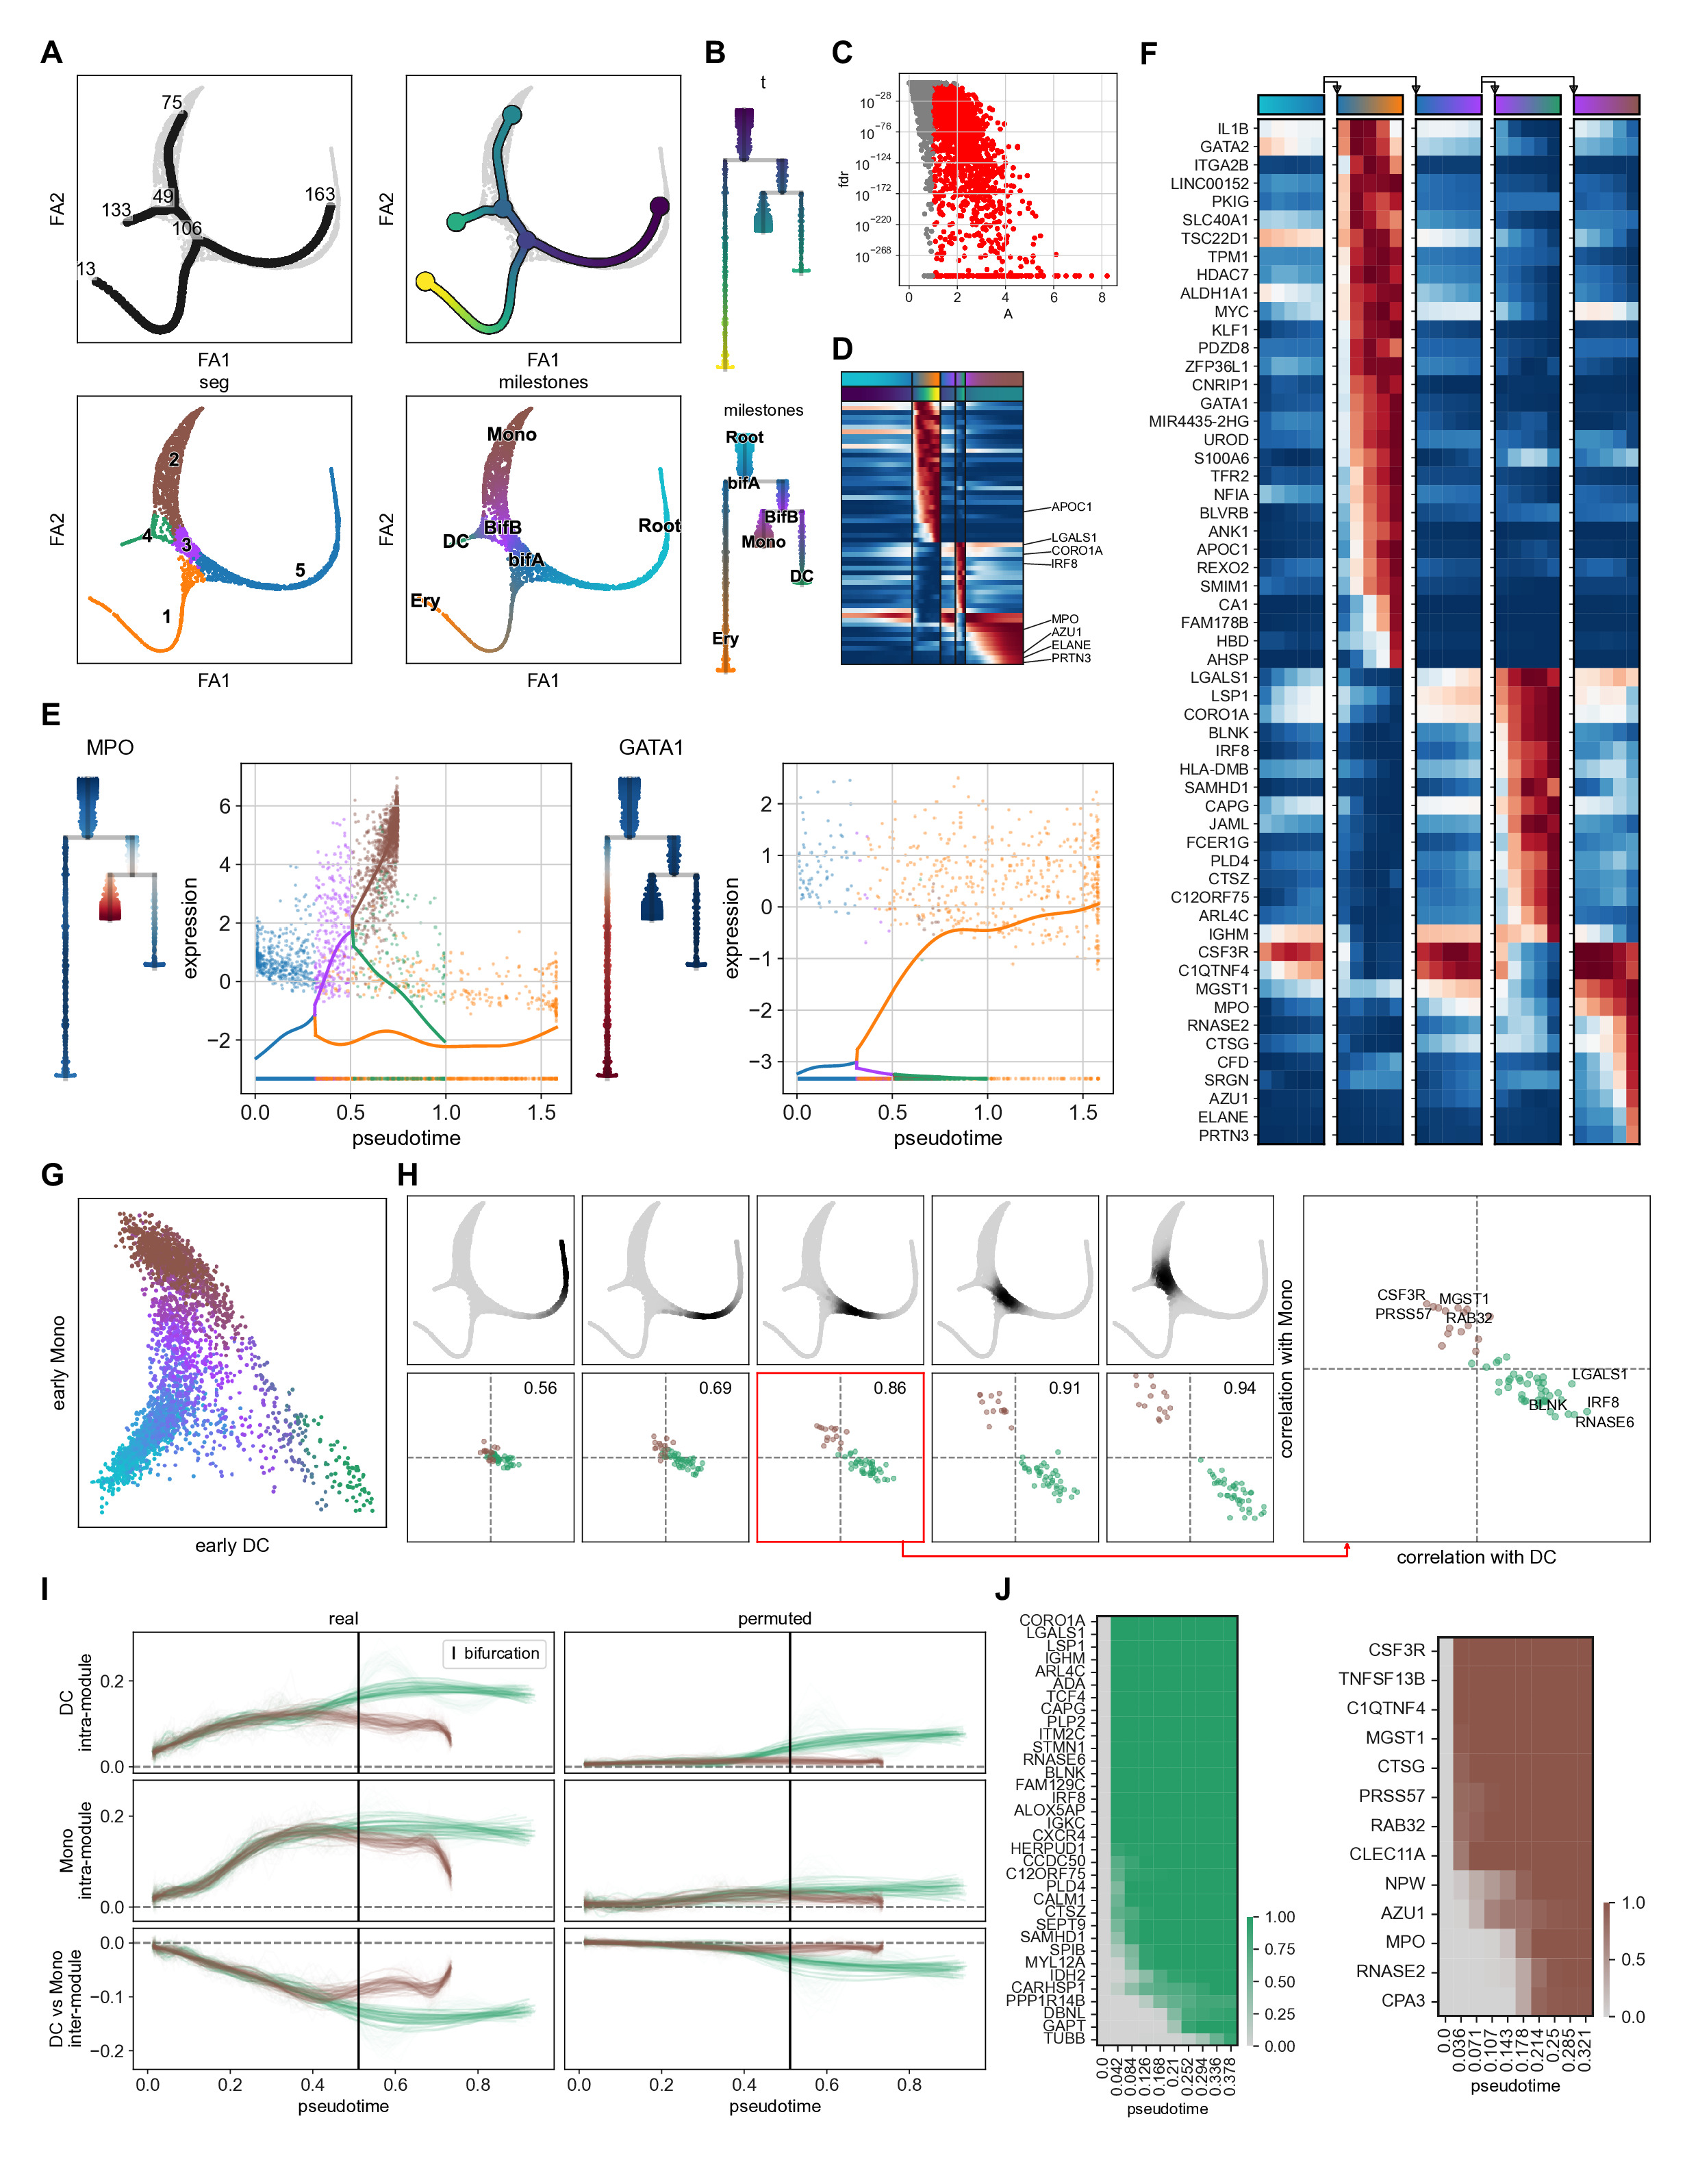

In [46]:
from IPython.display import Image
Image(filename=f'{fname}.jpg') 